# Librerias

In [14]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm

# Tratando datos
## El unico
Como esta dataset esta separado en varias carpeta lo que he decidido es por cada categoria crear un unico fichero donde se agrupe todo los datos de esta categoria

In [15]:
all_files_idle = glob.glob("data/idle/*.csv")
all_files_running = glob.glob("data/running/*.csv")
all_files_stairs = glob.glob("data/stairs/*.csv")
all_files_walking = glob.glob("data/walking/*.csv")

df_from_each_file_idle = (pd.read_csv(f) for f in all_files_idle)
df_from_each_file_running = (pd.read_csv(f) for f in all_files_running)
df_from_each_file_stairs = (pd.read_csv(f) for f in all_files_stairs)
df_from_each_file_walking = (pd.read_csv(f) for f in all_files_walking)

df_idle = pd.concat(df_from_each_file_idle, axis=0, ignore_index=True)
df_idle = df_idle.assign(action=0)

df_running = pd.concat(df_from_each_file_running, axis=0, ignore_index=True)
df_running = df_running.assign(action=1)

df_stairs = pd.concat(df_from_each_file_stairs, axis=0, ignore_index=True)
df_stairs = df_stairs.assign(action=2)

df_walking = pd.concat(df_from_each_file_walking, axis=0, ignore_index=True)
df_walking = df_walking.assign(action=3)

Generamos nuestro dataset (los 4 ficheros convertidos a 1) y printamos los 5 primeros elementos

In [16]:
df = pd.concat([df_idle, df_running, df_stairs, df_walking], axis=0, ignore_index=True)
df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,action
0,1.000776,4.616021,8.576031,0
1,0.718261,4.209007,8.446744,0
2,-0.909797,-0.282516,9.203311,0
3,5.099650,0.148441,8.418014,0
4,1.762132,-0.162806,9.251195,0


## Entender los datos
Miramos que no tengamos nulos antes de todo

In [17]:
df.isnull().sum()

accelerometer_X    0
accelerometer_Y    0
accelerometer_Z    0
action             0
dtype: int64

Mostramos descripcion de cada una para asi saber en que valores se encutran

In [18]:
print("IDLE", df_idle.describe(),"\n")
print("RUNNING",df_running.describe(),"\n")
print("STAIRS", df_stairs.describe(),"\n")
print("WALKING",df_walking.describe(),"\n")
print("DATASET", df.describe(),"\n")

IDLE        accelerometer_X  accelerometer_Y  accelerometer_Z   action
count     31170.000000     31170.000000     31170.000000  31170.0
mean          0.096767         2.225971         8.973247      0.0
std           0.691892         2.821235         1.211058      0.0
min         -10.448297        -2.595315        -0.296881      0.0
25%          -0.110133        -0.028730         8.116344      0.0
50%           0.234632         0.028730         9.749189      0.0
75%           0.277727         5.310340         9.773131      0.0
max           8.135497         9.916783        21.988348      0.0 

RUNNING        accelerometer_X  accelerometer_Y  accelerometer_Z    action
count    102240.000000    102240.000000    102240.000000  102240.0
mean          5.045705         8.083135         1.387356       1.0
std           9.952696        12.441402         7.004236       0.0
min         -39.188293       -39.188293       -39.188293       1.0
25%          -1.532289        -0.742202        -2.873042

Informacion de los datos

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193860 entries, 0 to 193859
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   action           193860 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 5.9 MB


In [20]:
def plot_3d_trajectory(i, x, y, z, title="3d trayectoria"):
    x = cumtrapz(x)
    y = cumtrapz(y)
    z = cumtrapz(z)
    
    fig3,ax = plt.subplots()
    fig3.suptitle(title,fontsize=20)
    ax = plt.axes(projection='3d')
    ax.plot3D(x,y,z)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')

In [21]:
def plot_3d_scatter(x, y, z, action, title="3d puntos"):
    # Creating color map
    my_cmap = plt.get_cmap('brg')
    
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
 
    sctt = ax.scatter3D(x, y, z,
                        alpha = 0.2,
                        c = action,
                        cmap = my_cmap,
                        marker ='o')
                        
    plt.title(title)
    ax.set_xlabel('Eje x')
    ax.set_ylabel('Eje y')
    ax.set_zlabel('Eje z')
    fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
    plt.show()

mostramos la distribucion de los datos

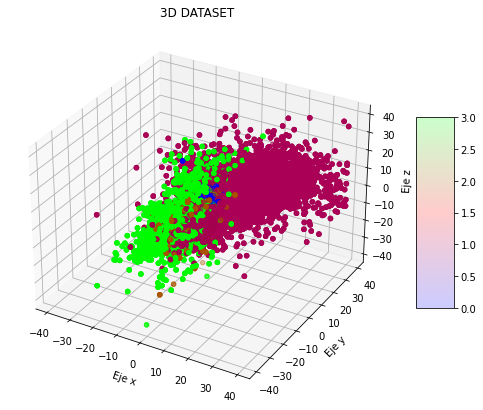

In [22]:
#plot_3d_scatter(df_idle['accelerometer_X'], df_idle['accelerometer_Y'], df_idle['accelerometer_Z'], df_idle['action'], "3D IDLE")
#plot_3d_scatter(df_running['accelerometer_X'], df_running['accelerometer_Y'], df_running['accelerometer_Z'], df_running['action'], "3D RUNNING")
#plot_3d_scatter(df_walking['accelerometer_X'], df_walking['accelerometer_Y'], df_walking['accelerometer_Z'], df_walking['action'], "3D WALKING")
#plot_3d_scatter(df_stairs['accelerometer_X'], df_stairs['accelerometer_Y'], df_stairs['accelerometer_Z'], df_stairs['action'],  "3D STAIRS")
plot_3d_scatter(df['accelerometer_X'], df['accelerometer_Y'], df['accelerometer_Z'], df['action'],  "3D DATASET")

# Creacion del Modelo

## Antes de todo
Vamos a dividir nuestro dataset en entreno y test, personalmente me gusta la distribucion de 70% entreno y el 30% restante para el test

In [23]:
X = df[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
Y = df['action']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Clasificador

### SVM

Entrenamos nuestro modelo

In [24]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

SVC()

Vamos ha ver que tal efectivo es

In [25]:
print("Efectividad del entreno:", svm_model.score(X_train, y_train))
print("Efectividad del test: ", svm_model.score(X_test, y_test))

Efectividad del entreno: 0.8943954400082533
Efectividad del test:  0.8920612813370473


vamos ha hecharle un vistazo a nuestra matriz de confusion, podemos observar que para las clases 0,1 y 3 tenemos muy buena clasificacion, oeri sin embargo para la clase 2 ha fallado bastante

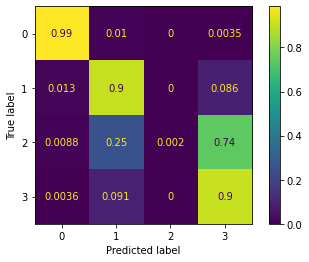

In [26]:
ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test, normalize='true')